# Feature Engineering

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os
from sklearn.ensemble import RandomForestRegressor

In [2]:
# add the src directory to path to import custom modules
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
# import custom modules
from src.data.preprocess import load_data, save_processed_data
from src.features.build_features import (
    handle_missing_values,
    extract_temporal_features,
    encode_categorical_features,
    transform_numeric_features,
    create_interaction_features,
    select_features
)

In [4]:
# load the raw data
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')

In [5]:
# handle missing values
print('Step 1: Handling mising values...')
train_data_imputed = handle_missing_values(train_data, strategy='median')
test_data_imputed = handle_missing_values(test_data, strategy='median')

Step 1: Handling mising values...


In [6]:
# extract temporal features
print('Step 2: Extracting temporal features...')
train_data_temporal = extract_temporal_features(train_data_imputed)
test_data_temporal = extract_temporal_features(test_data_imputed)

Step 2: Extracting temporal features...


In [7]:
# verify no datetime columns remain
datetime_cols = train_data_temporal.select_dtypes(include=['datetime64']).columns.tolist()
if datetime_cols:
    print(f"Warning: datetime columns still present after extraction: {datetime_cols}")
    train_data_temporal = train_data_temporal.drop(columns=datetime_cols)
    test_data_temporal = test_data_temporal.drop(columns=datetime_cols)

In [8]:
# transform numeric features
print('Step 3: Transforming numeric features...')
# log transform the target variable and other skewed variables
log_transform_cols = [
    'Annual Turnover',  # Target variable
    'Facebook Popularity Quotient',
    'Instagram Popularity Quotient',
    'restaurant_age_days',  # This will be created from 'Opening Day of Restaurant'
    'Live Music Rating',
    'Comedy Gigs Rating',
    'Value Deals Rating',
    'Live Sports Rating'
]
train_data_transformed = transform_numeric_features(train_data_temporal, log_transform=log_transform_cols)
test_data_transformed = transform_numeric_features(test_data_temporal, log_transform=log_transform_cols)

Step 3: Transforming numeric features...


In [9]:
# create interaction features
print('Step 4: Creating interaction features...')
train_data_interactions = create_interaction_features(train_data_transformed)
test_data_interactions = create_interaction_features(test_data_transformed)

Step 4: Creating interaction features...


In [10]:
# encode categorical features
print('Step 5: Encoding categorical features...')
# use target encoding for high-cardinality features
train_data_encoded = encode_categorical_features(train_data_interactions, target_col='Annual Turnover')
# apply the same encoding to test data (without using target information)
test_data_encoded = encode_categorical_features(test_data_interactions)

Step 5: Encoding categorical features...


In [11]:
# verify no object columns remain
object_cols = train_data_encoded.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"Warning: Object columns still present after encoding: {object_cols}")
    # apply simple label encoding to any remaining object columns
    for col in object_cols:
        train_data_encoded[col] = train_data_encoded[col].astype('category').cat.codes
        if col in test_data_encoded.columns:
            test_data_encoded[col] = test_data_encoded[col].astype('category').cat.codes

In [12]:
# feature selection
print('Step 6: Selecting features...')

# seperate features and target
X_train = train_data_encoded.drop(['Annual Turnover', 'Annual Turnover_log', 'Registration Number'], axis=1)
y_train = train_data_encoded['Annual Turnover_log'] # using log transformed target

Step 6: Selecting features...


In [13]:
# final safety check for any remaining problematic data types
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns.tolist()
if datetime_cols:
    print(f"Removing remaining datetime columns: {datetime_cols}")
    X_train = X_train.drop(columns=datetime_cols)

In [14]:
# select top features
X_train_selected, selected_features = select_features(X_train, y_train, k=20)

# apply feature selection to test data
X_test = test_data_encoded[selected_features]

In [15]:
# save processed data
print('Saving processed data...')
save_processed_data(X_train_selected, y_train, X_test, test_data_encoded['Registration Number'], '../data/processed/')
print('Feature engineering complete!')

Saving processed data...
Saved processed training data: (3493, 21)
Saved processed test data: (500, 21)
Feature engineering complete!


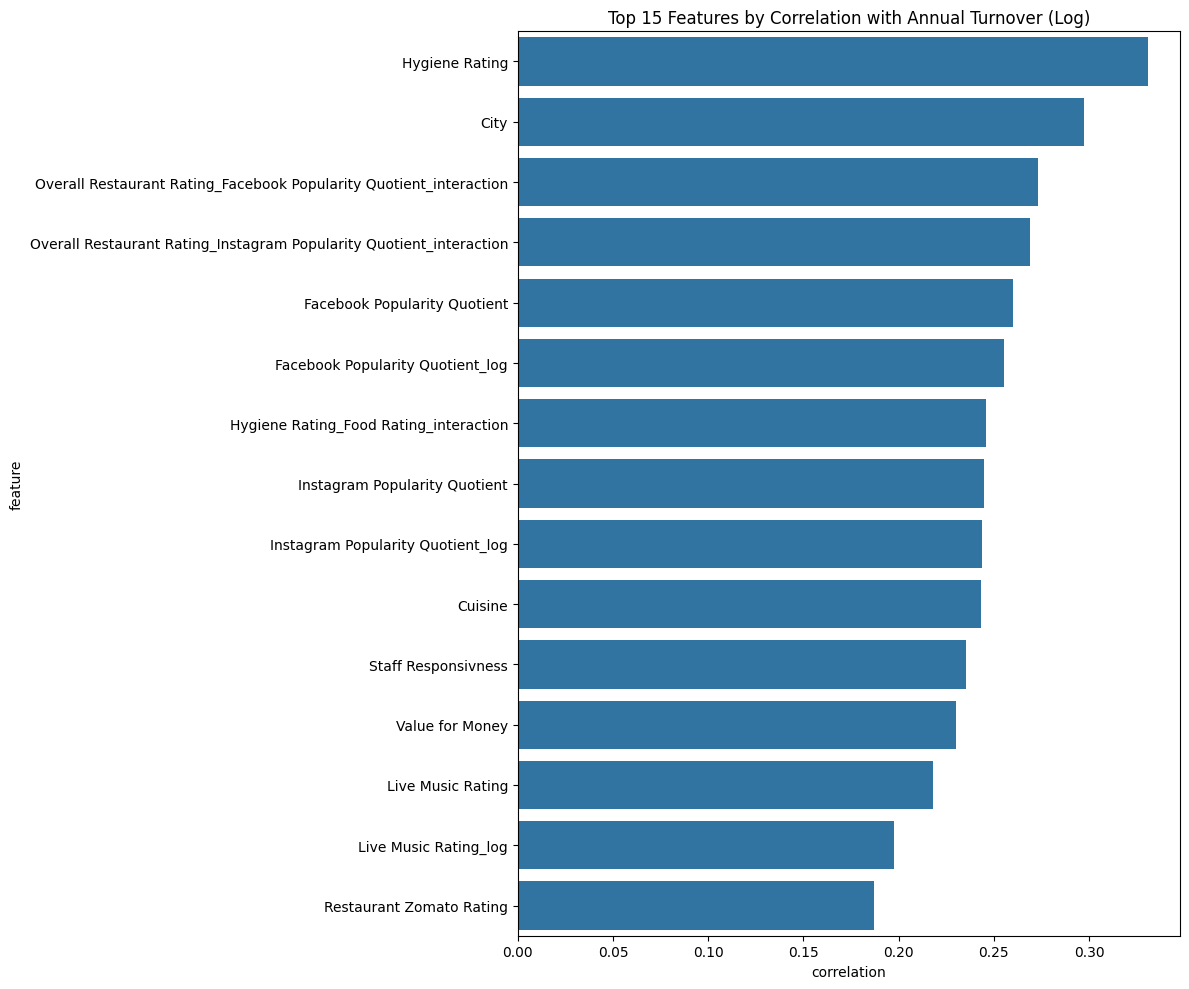

In [17]:
# correlation with target
plt.figure(figsize=(12, 10))
corr_with_target = pd.DataFrame({
    'feature': X_train.columns,
    'correlation': [X_train[col].corr(y_train) for col in X_train.columns]
}).sort_values('correlation', ascending=False)

sns.barplot(x='correlation', y='feature', data=corr_with_target.head(15))
plt.title('Top 15 Features by Correlation with Annual Turnover (Log)')
plt.tight_layout()
plt.savefig('../reports/figures/top_feature_correlations.png')
plt.show()

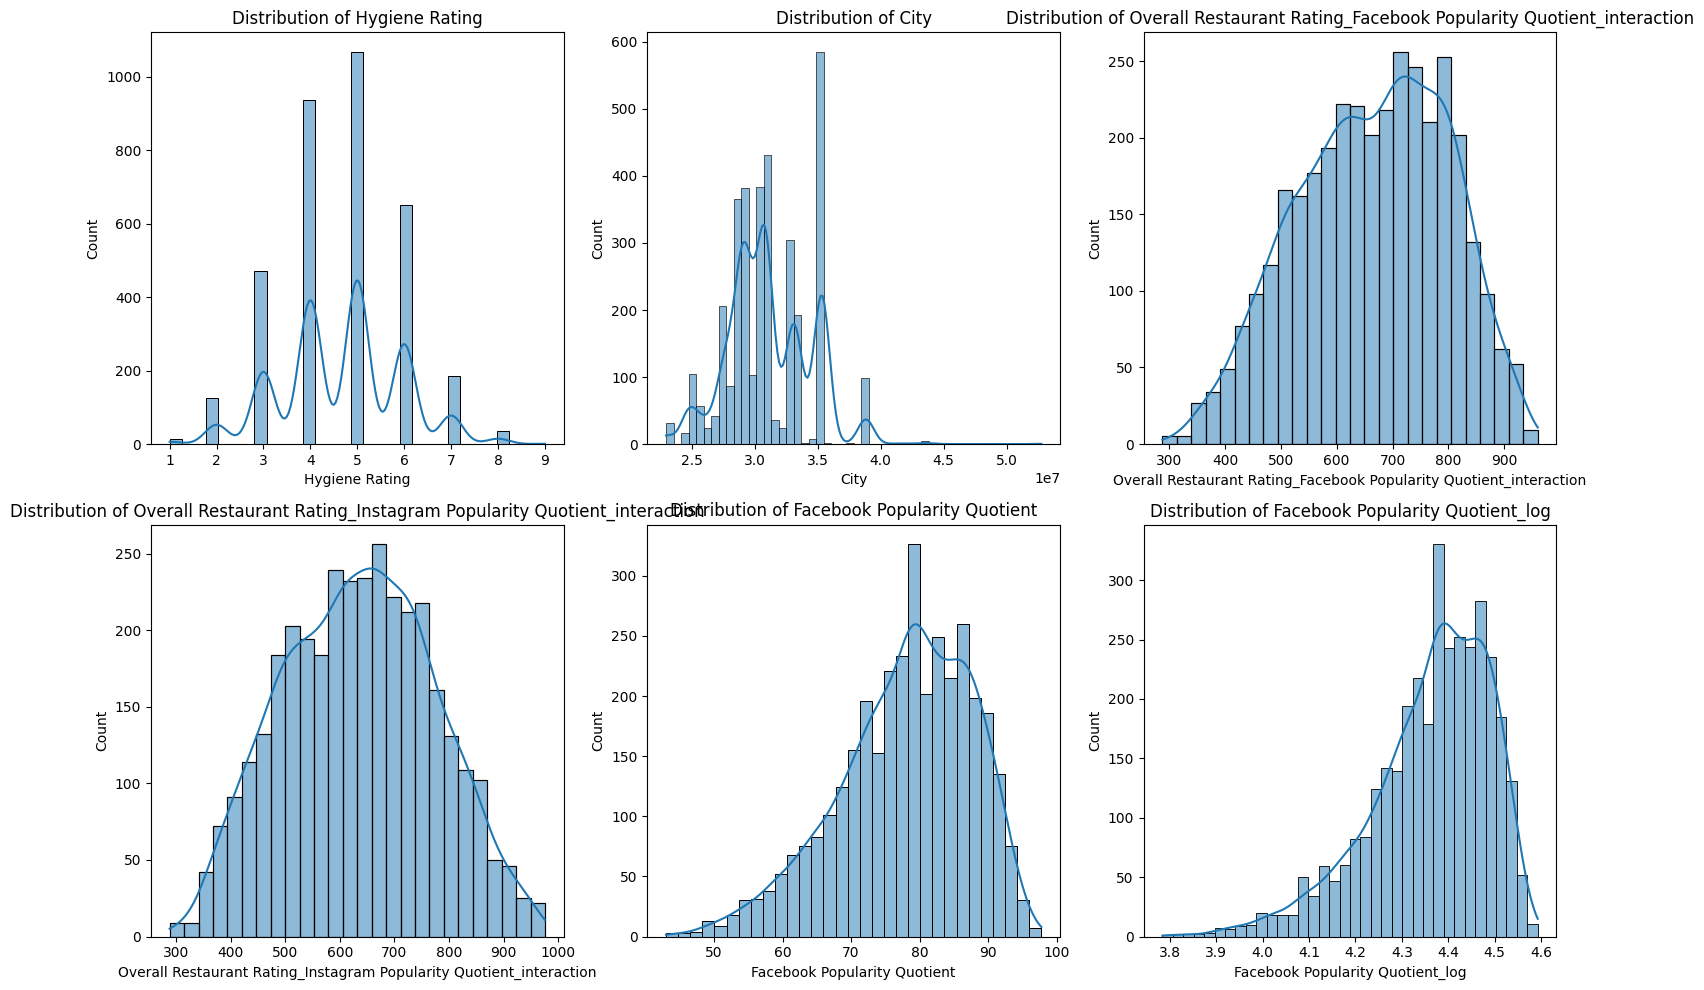

In [19]:
# feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(corr_with_target['feature'].head(6)):
    plt.subplot(2, 3, i+1)
    sns.histplot(X_train[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.savefig('../reports/figures/top_feature_distributions.png')
plt.show()

In [21]:
# train a simple random forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

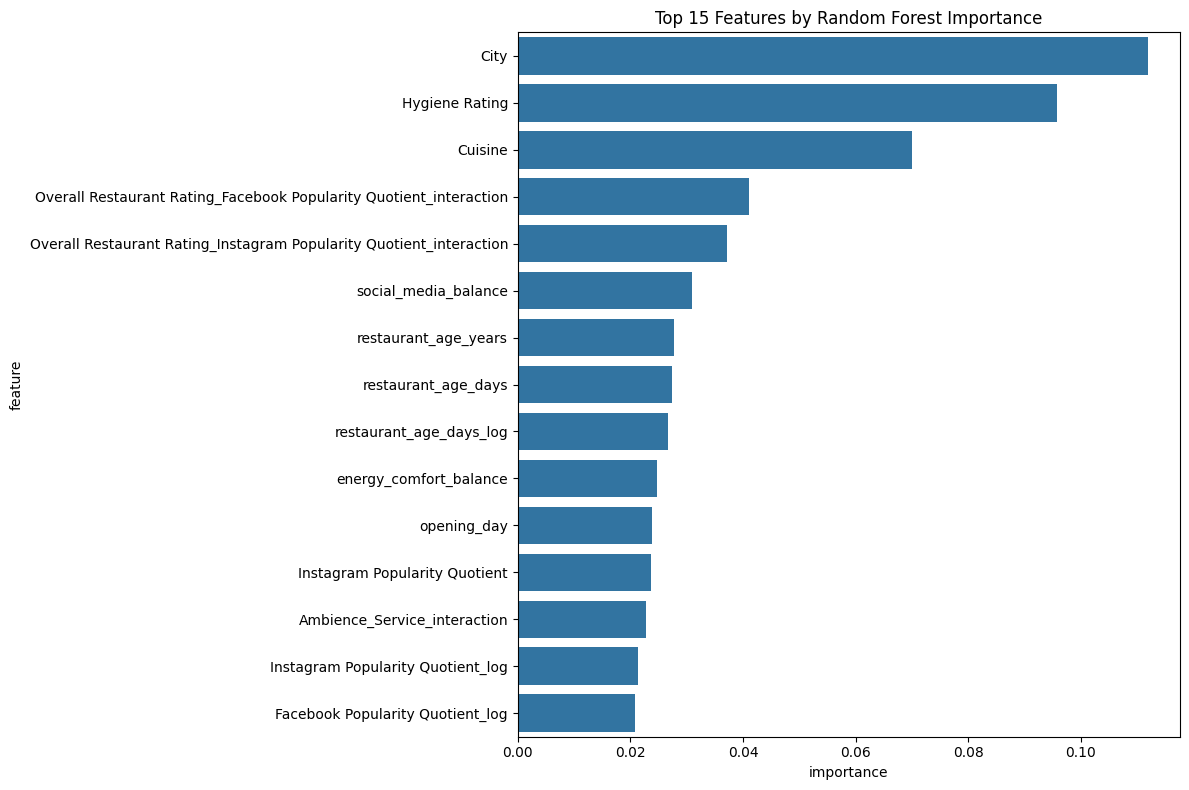

In [22]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Random Forest Importance')
plt.tight_layout()
plt.savefig('../reports/figures/rf_feature_importance.png')
plt.show()